# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [93]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu') # for debugging
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [94]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [95]:
torch.__version__

'2.1.0+cu121'

In [96]:
torchtext.__version__

'0.16.0+cpu'

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Download Thai font package so the Thai tokens are readable in the attention heatmap

!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

import matplotlib as mpl

mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

replace THSarabunChula-Regular.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


## 1. ETL: Loading the dataset

The dataset is a large English-Thai Parallel Corpus from [Hugging Face](https://huggingface.co/datasets/scb_mt_enth_2020).

In [99]:
!pip install datasets

In [100]:
import datasets

In [101]:
dataset = datasets.load_dataset('scb_mt_enth_2020', 'enth')

In [102]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 801402
    })
    validation: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100173
    })
    test: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100177
    })
})

## 2. EDA - simple investigation

In [103]:
#let's take a look at one example of train
sample = dataset['train'][0]['translation']
print(sample['en']+'\n'+sample['th'])

FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]
(ซ้ายสุด) นายติโต คาร์นาเวียน ผู้บัญชาการตํารวจแห่งชาติอินโดนีเซีย (จากซ้าย) นายโรนัลด์ เดลา โรซา ผู้บัญชาการตํารวจแห่งชาติฟิลิปปินส์ และนายคาลิด อาบู บาการ์ ผู้บัญชาการตํารวจแห่งชาติมาเลเซีย ไขว้แขนกันก่อนเริ่มการประชุมความมั่นคงไตรภาคีในเมืองปาเซย์ ซึ่งอยู่ทางตะวันออกเฉียงใต้ของกรุงมะนิลา ประเทศฟิลิปปินส์ ในเดือนมิถุนายน พ.ศ. 2560 ดิแอสโซซิเอทเต็ด เพรส


In [104]:
for a, b in list(dataset.items()):
    print(f'{a.capitalize()}: {len(b)} rows')

Train: 801402 rows
Validation: 100173 rows
Test: 100177 rows


Because of limited memory, a sliver of dataset is used to trained the model.

You can change the number of the data as you see fit.

In [105]:
train_data = dataset['train'][:200]
val_data = dataset['validation'][:40]
test_data = dataset['test'][:40]

## 3. Preprocessing

### Tokenizing

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

For English texts, PyTorch tokenizer is used to tokenize.\
For Thai texts, PyThaiNLP tokenizer is used to tokenize.

The procedure is shown below.

In [106]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [107]:
!pip install pythainlp

In [108]:
# token text using supported tokenizer

from torchtext.data.utils import get_tokenizer
from pythainlp import word_tokenize
token_transform['en'] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform['th'] = word_tokenize

In [109]:
print("Sentence: ", sample['en'])
print("Tokenization: ", token_transform['en'](sample['en']))

Sentence:  FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]
Tokenization:  ['FAR', 'LEFT', ':', 'Indonesian', 'National', 'Police', 'Chief', 'Tito', 'Karnavian', ',', 'from', 'left', ',', 'Philippine', 'National', 'Police', 'Chief', 'Ronald', 'Dela', 'Rosa', 'and', 'Royal', 'Malaysian', 'Police', 'Inspector', 'General', 'Khalid', 'Abu', 'Bakar', 'link', 'arms', 'before', 'the', 'Trilateral', 'Security', 'Meeting', 'in', 'Pasay', 'city', ',', 'southeast', 'of', 'Manila', ',', 'Philippines', ',', 'in', 'June', '2017', '.', '[', 'THE', 'ASSOCIATED', 'PRESS', ']']


In [110]:
print("Sentence: ", sample['th'])
print("Tokenization: ", token_transform['th'](sample['th']))

Sentence:  (ซ้ายสุด) นายติโต คาร์นาเวียน ผู้บัญชาการตํารวจแห่งชาติอินโดนีเซีย (จากซ้าย) นายโรนัลด์ เดลา โรซา ผู้บัญชาการตํารวจแห่งชาติฟิลิปปินส์ และนายคาลิด อาบู บาการ์ ผู้บัญชาการตํารวจแห่งชาติมาเลเซีย ไขว้แขนกันก่อนเริ่มการประชุมความมั่นคงไตรภาคีในเมืองปาเซย์ ซึ่งอยู่ทางตะวันออกเฉียงใต้ของกรุงมะนิลา ประเทศฟิลิปปินส์ ในเดือนมิถุนายน พ.ศ. 2560 ดิแอสโซซิเอทเต็ด เพรส
Tokenization:  ['(', 'ซ้าย', 'สุด', ')', ' ', 'นา', 'ยติ', 'โต', ' ', 'คาร์', 'นา', 'เวียน', ' ', 'ผู้บัญชาการ', 'ตํารวจ', 'แห่งชาติ', 'อินโดนีเซีย', ' ', '(', 'จาก', 'ซ้าย', ')', ' ', 'นาย', 'โร', 'นัลด์', ' ', 'เด', 'ลา', ' ', 'โร', 'ซา', ' ', 'ผู้บัญชาการ', 'ตํารวจ', 'แห่งชาติ', 'ฟิลิปปินส์', ' ', 'และ', 'นาย', 'คา', 'ลิด', ' ', 'อา', 'บู', ' ', 'บา', 'การ์', ' ', 'ผู้บัญชาการ', 'ตํารวจ', 'แห่งชาติ', 'มาเลเซีย', ' ', 'ไขว้', 'แขน', 'กัน', 'ก่อน', 'เริ่ม', 'การประชุม', 'ความมั่นคง', 'ไตรภาคี', 'ใน', 'เมือง', 'ปา', 'เซย์', ' ', 'ซึ่ง', 'อยู่', 'ทาง', 'ตะวันออกเฉียงใต้', 'ของ', 'กรุง', 'มะนิลา', ' ', 'ประเทศ', 'ฟิลิปปินส์', 

A function to tokenize our input.

In [111]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    valid_lang = ('en', 'th')
    if language not in valid_lang:
        raise ValueError("The input language must be 'en' for English or 'th' for Thai.")
    for data_sample in data['translation']:
        yield token_transform[language](data_sample[language])

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [112]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [113]:
from torchtext.vocab import build_vocab_from_iterator

for ln in ['en', 'th']:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in ['en', 'th']:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [114]:
#see some example
vocab_transform['en'](['here', 'is', 'a', 'unknownword', 'a'])

[0, 37, 11, 0, 11]

In [115]:
#we can reverse it....
mapping = vocab_transform['en'].get_itos()

#print 1816, for example
mapping[0]

'<unk>'

In [116]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [117]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [118]:
#check unique vocabularies
len(mapping)

942

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [119]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in ['en', 'th']:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform['en'](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform['th'](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [120]:
next(iter(train_data['translation']))

{'en': 'FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]',
 'th': '(ซ้ายสุด) นายติโต คาร์นาเวียน ผู้บัญชาการตํารวจแห่งชาติอินโดนีเซีย (จากซ้าย) นายโรนัลด์ เดลา โรซา ผู้บัญชาการตํารวจแห่งชาติฟิลิปปินส์ และนายคาลิด อาบู บาการ์ ผู้บัญชาการตํารวจแห่งชาติมาเลเซีย ไขว้แขนกันก่อนเริ่มการประชุมความมั่นคงไตรภาคีในเมืองปาเซย์ ซึ่งอยู่ทางตะวันออกเฉียงใต้ของกรุงมะนิลา ประเทศฟิลิปปินส์ ในเดือนมิถุนายน พ.ศ. 2560 ดิแอสโซซิเอทเต็ด เพรส'}

In [121]:
def extractor(input):
    return [list(d.values()) for d in input]

In [122]:
batch_size = 32

train_loader = DataLoader(extractor(train_data['translation']), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(extractor(val_data['translation']),   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(extractor(test_data['translation']),  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [123]:
for en, _, th in train_loader:
    break

In [124]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([32, 111])
Thai shape:  torch.Size([32, 148])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [125]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, att_mech):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, att_mech)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [126]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, att_mech, max_length = 512):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, att_mech)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [127]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, att_mech):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        self.dropout  = nn.Dropout(dropout)

        self.mech = att_mech # scaled dot-product, general, multiplicative, additive

        if self.mech == 'scaled dot-product':
            self.scale  = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        elif self.mech == 'general':
            pass
        elif self.mech == 'multiplicative':
            self.W      = nn.Linear(self.head_dim, self.head_dim)
        elif self.mech == 'additive':
            self.W1     = nn.Linear(self.head_dim, self.head_dim)
            self.W2     = nn.Linear(self.head_dim, self.head_dim)
            self.V      = nn.Linear(self.head_dim, 1)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query) # s
        K = self.fc_k(key) # h
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        ## add energy types
        if self.mech == 'scaled dot-product':
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'general':
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.mech == 'multiplicative':
            energy = torch.matmul(self.W(Q), K.permute(0, 1, 3, 2))
        elif self.mech == 'additive':
            energy = self.V(torch.tanh(self.W1(Q.unsqueeze(3)) + self.W2(K.unsqueeze(2)))).squeeze(-1)
        else:
            raise ValueError(f"{self.mech} is not a valid attention mech: scaled dot-product, general, multiplicative, additive")

        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention


### Position-wise Feedforward Layer

In [128]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [129]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, att_mech):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, att_mech)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, att_mech)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [130]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device, att_mech, max_length = 512):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, att_mech)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [131]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [132]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [133]:
INPUT_DIM = len(vocab_transform['en'])
OUTPUT_DIM = len(vocab_transform['th'])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

att_mech = 'general'

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device,
              att_mech)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              att_mech)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [134]:
print(enc)

Encoder(
  (tok_embedding): Embedding(942, 256)
  (pos_embedding): Embedding(512, 256)
  (layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforward): PositionwiseFeedforwardLayer(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dro

In [135]:
input_dim   = len(vocab_transform['en'])
output_dim  = len(vocab_transform['th'])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

att_mech = 'general'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              att_mech)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              att_mech)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(942, 256)
    (pos_embedding): Embedding(512, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [136]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

241152
131072
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
285696
131072
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
285696
  1116
______
5029468


In [137]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [138]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # print(f"src shape: {src.shape}")
        # print(f"trg shape: {trg.shape}")

        # print(f"Max index in source: {src.max().item()}, Source vocab size: {len(vocab_transform['en'])}")
        # print(f"Max index in target: {trg.max().item()}, Target vocab size: {len(vocab_transform['th'])}")

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [139]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [140]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [141]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [142]:
import gc
gc.collect()

num_epochs = 10
clip       = 1

train_losses = {}
valid_losses = {}

torch.cuda.reset_max_memory_allocated()

for att_mech in ['additive']:

    enc = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim,
                enc_dropout, device, att_mech)

    dec = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim,
                enc_dropout, device, att_mech)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    lr = 0.0005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    best_valid_loss = float('inf')

    save_path = f'/content/drive/MyDrive/Colab/Model/MT_enth_{att_mech}_'

    train_losses[att_mech] = []
    valid_losses[att_mech] = []

    print(att_mech)

    try:
        for epoch in range(num_epochs):

            start_time = time.time()

            train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
            valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

            #for plotting
            train_losses[att_mech].append(train_loss)
            valid_losses[att_mech].append(valid_loss)

            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)


            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_path+'best.pt')

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

            #lower perplexity is better
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f'CUDA out of memory at epoch {epoch}')
        else:
            raise e

    torch.save(model.state_dict(), save_path+f'e{epoch}.pt')

    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()

    print(f'GPU memory allocated: {torch.cuda.max_memory_allocated()}')
    torch.cuda.reset_max_memory_allocated()


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


additive
Epoch: 01 | Time: 0m 2s
	Train Loss: 6.215 | Train PPL: 500.205
	 Val. Loss: 4.384 |  Val. PPL:  80.181
Epoch: 02 | Time: 0m 2s
	Train Loss: 5.586 | Train PPL: 266.550
	 Val. Loss: 4.021 |  Val. PPL:  55.754
Epoch: 03 | Time: 0m 2s
	Train Loss: 5.437 | Train PPL: 229.856
	 Val. Loss: 3.960 |  Val. PPL:  52.446
Epoch: 04 | Time: 0m 2s
	Train Loss: 5.392 | Train PPL: 219.555
	 Val. Loss: 3.992 |  Val. PPL:  54.155
Epoch: 05 | Time: 0m 2s
	Train Loss: 5.361 | Train PPL: 212.896
	 Val. Loss: 3.821 |  Val. PPL:  45.644
Epoch: 06 | Time: 0m 2s
	Train Loss: 5.239 | Train PPL: 188.481
	 Val. Loss: 3.831 |  Val. PPL:  46.092
CUDA out of memory at epoch 6
GPU memory allocated: 13381516288


In [143]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10, 6))
# mech_list = train_losses.keys()
# for i, mech in enumerate(mech_list):
#     ax = fig.add_subplot(2, 2, i+1)
#     ax.plot(train_losses[mech], label = 'train loss')
#     ax.plot(valid_losses[mech], label = 'valid loss')
#     ax.legend()
#     ax.set_xlabel('updates')
#     ax.set_ylabel('loss')
#     ax.set_title(mech)

# plt.tight_layout()
# plt.show()

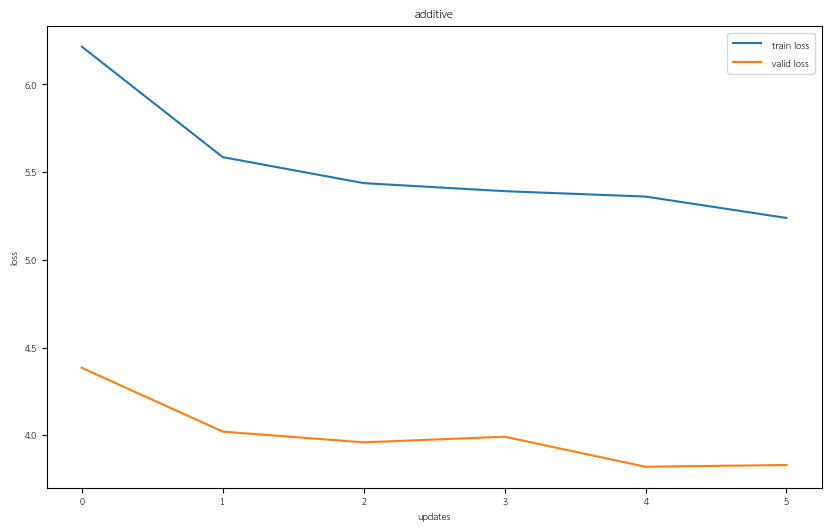

In [144]:
import matplotlib.pyplot as plt

images_dir = '/content/drive/MyDrive/Colab/Model'

mech_list = list(train_losses.keys())

for mech in mech_list:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses[mech], label = 'train loss')
    ax.plot(valid_losses[mech], label = 'valid loss')
    plt.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')
    ax.set_title(f'{mech}')
    plt.savefig(f"{images_dir}/loss_{mech}.png")

In [145]:
for mech in mech_list:

    enc = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim,
                enc_dropout, device, mech)

    dec = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim,
                enc_dropout, device, mech)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab/Model/MT_enth_{mech}_best.pt"))
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)

    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.746 | Test PPL:  42.361 |


## 7. Test on some random news

In [146]:
sample['en']

'FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]'

In [147]:
sample['th']

'(ซ้ายสุด) นายติโต คาร์นาเวียน ผู้บัญชาการตํารวจแห่งชาติอินโดนีเซีย (จากซ้าย) นายโรนัลด์ เดลา โรซา ผู้บัญชาการตํารวจแห่งชาติฟิลิปปินส์ และนายคาลิด อาบู บาการ์ ผู้บัญชาการตํารวจแห่งชาติมาเลเซีย ไขว้แขนกันก่อนเริ่มการประชุมความมั่นคงไตรภาคีในเมืองปาเซย์ ซึ่งอยู่ทางตะวันออกเฉียงใต้ของกรุงมะนิลา ประเทศฟิลิปปินส์ ในเดือนมิถุนายน พ.ศ. 2560 ดิแอสโซซิเอทเต็ด เพรส'

In [148]:
src_text = text_transform['en'](sample['en']).to(device)
src_text

tensor([  2,   0,   0,  28, 239, 106, 364, 555,   0,   0,   4,  34,  98,   4,
        142, 106, 364, 555,   0,   0,   0,   9, 612,   0, 364,   0, 346,   0,
          0,   0,   0,   0, 125,   5,   0, 144, 593,   8,   0, 262,   4, 890,
          7, 164,   4, 118,   4,   8, 104,  35,   6, 377,   0,   0,   0, 378,
          3], device='cuda:0')

In [149]:
trg_text = text_transform['th'](sample['th']).to(device)
trg_text

tensor([   2,   19,  149,    0,   21,    4,  107,    0,  298,    4,  541,  107,
        1065,    4,  266,  327,  189,   93,    4,   19,   25,  149,   21,    4,
          18,  299,    0,    4,  491,  628,    4,  299,  822,    4,  266,  327,
         189,   79,    4,    8,   18,  799,    0,    4,  484,    0,    4,  889,
           0,    4,  266,  327,  189,  618,    4,    0,    0,  192,  248,  241,
         146,   96,    0,    5,  133,  906,    0,    4,   15,  121,   51,  836,
           7,   72,  342,    4,   32,   79,    4,    5,   33,  182,    4,   11,
           4,   47,    4,  150,  245,   71,  246,  256,  134,  260,    4,  240,
           3], device='cuda:0')

In [150]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [151]:
trg_text = trg_text.reshape(1, -1)

In [152]:
src_text.shape, trg_text.shape

(torch.Size([1, 57]), torch.Size([1, 97]))

In [153]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [154]:
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab/Model/MT_enth_{mech}_best.pt"))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [155]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 97, 1116])

Since batch size is 1, we just take off that dimension

In [156]:
output = output.squeeze(0)

In [157]:
output.shape

torch.Size([97, 1116])

We shall remove the first token since it's zeroes anyway

In [158]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([96, 1116])

Then we just take the top token with highest probabilities

In [159]:
output_max = output.argmax(1) #returns max indices

In [160]:
output_max

tensor([4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4,
        4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4,
        0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4,
        4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4],
       device='cuda:0')

Get the mapping of the target language

In [161]:
mapping = vocab_transform['th'].get_itos()

In [162]:
for token in output_max:
    print(mapping[token.item()])

 
 
 
 
<unk>
 
 
 
<unk>
 
 
 
<unk>
 
 
 
 
<unk>
 
 
 
 
<unk>
 
 
 
<unk>
 
 
<unk>
 
 
<unk>
 
 
 
 
<unk>
 
 
 
 
<unk>
 
 
<unk>
 
 
<unk>
 
 
 
 
<unk>
 
 
 
 
 
 
 
 
 
 
 
 
<unk>
 
 
 
 
 
 
 
<unk>
 
 
<unk>
 
 
 
<unk>
 
<unk>
 
<unk>
 
 
 
 
 
 
 
<unk>
 
 


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [163]:
attentions.shape

torch.Size([1, 8, 97, 57])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [164]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([97, 57])

In [165]:
src_tokens = ['<sos>'] + token_transform['en'](sample['en']) + ['<eos>']
src_tokens

['<sos>',
 'FAR',
 'LEFT',
 ':',
 'Indonesian',
 'National',
 'Police',
 'Chief',
 'Tito',
 'Karnavian',
 ',',
 'from',
 'left',
 ',',
 'Philippine',
 'National',
 'Police',
 'Chief',
 'Ronald',
 'Dela',
 'Rosa',
 'and',
 'Royal',
 'Malaysian',
 'Police',
 'Inspector',
 'General',
 'Khalid',
 'Abu',
 'Bakar',
 'link',
 'arms',
 'before',
 'the',
 'Trilateral',
 'Security',
 'Meeting',
 'in',
 'Pasay',
 'city',
 ',',
 'southeast',
 'of',
 'Manila',
 ',',
 'Philippines',
 ',',
 'in',
 'June',
 '2017',
 '.',
 '[',
 'THE',
 'ASSOCIATED',
 'PRESS',
 ']',
 '<eos>']

In [166]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '<unk>',
 ' ',
 ' ']

In [167]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='viridis')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    cbar = fig.colorbar(cax)

    plt.show()

    plt.savefig(f"{images_dir}/attention_{mech}.png")

    plt.close()

In [168]:
print(sample['en'])
print(sample['th'])
print('=============\n')
attentions = {}

for mech in mech_list:
    print(f'Attention: {mech}')

    enc = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim,
                enc_dropout, device, mech)

    dec = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim,
                enc_dropout, device, mech)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab/Model/MT_enth_{mech}_best.pt"))
    model.eval()
    with torch.no_grad():
        output, attention = model(src_text, trg_text) #turn off teacher forcing
    attention = attention[0, 0, :, :]
    attentions[mech] = attention
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1)
    mapping = vocab_transform['th'].get_itos()

    for token in output_max:
        print(mapping[token.item()], end='')
    print('\n')

FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]
(ซ้ายสุด) นายติโต คาร์นาเวียน ผู้บัญชาการตํารวจแห่งชาติอินโดนีเซีย (จากซ้าย) นายโรนัลด์ เดลา โรซา ผู้บัญชาการตํารวจแห่งชาติฟิลิปปินส์ และนายคาลิด อาบู บาการ์ ผู้บัญชาการตํารวจแห่งชาติมาเลเซีย ไขว้แขนกันก่อนเริ่มการประชุมความมั่นคงไตรภาคีในเมืองปาเซย์ ซึ่งอยู่ทางตะวันออกเฉียงใต้ของกรุงมะนิลา ประเทศฟิลิปปินส์ ในเดือนมิถุนายน พ.ศ. 2560 ดิแอสโซซิเอทเต็ด เพรส

Attention: additive
    <unk>   <unk>   <unk>    <unk>    <unk>   <unk>  <unk>  <unk>    <unk>    <unk>  <unk>  <unk>    <unk>            <unk>       <unk>  <unk>   <unk> <unk> <unk>       <unk>  



Attention: additive


<ipython-input-167-749d300861a3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-167-749d300861a3>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


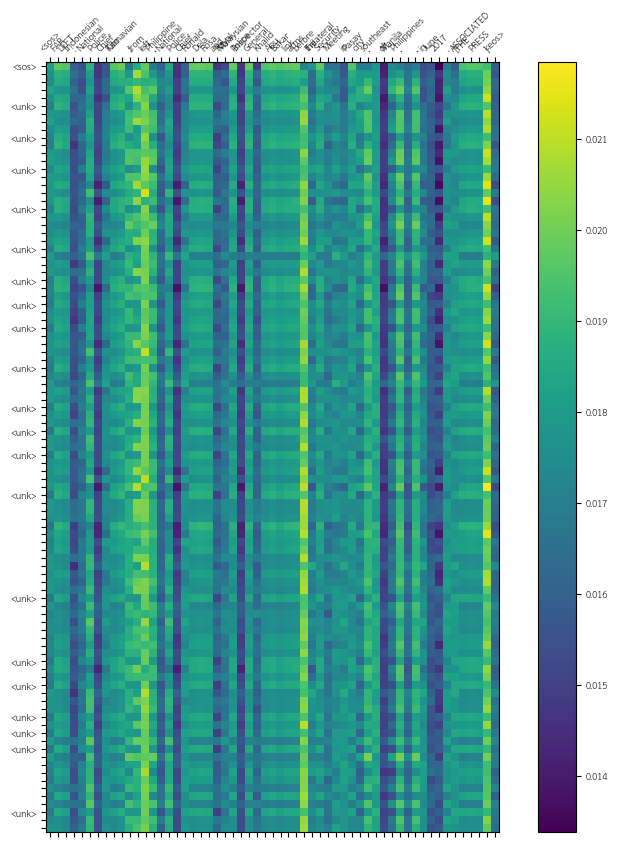

In [169]:
print(f'Attention: {mech_list[0]}')
display_attention(src_tokens, trg_tokens, attentions[mech_list[0]])